# Rossmann 销售预测 -- 特征工程

> 特征工程决定了机器学习的上限，算法只是在逼近这个上限。

在这个notebook中，我将对原始数据进行特征工程。以得到便于机器学习算法进行计算和优化，而且不会由于数据本身产生偏差的训练集和测试集。

## 1. Adam

在这一部分，我将对原始数据实施剔除、编码和重新组合等操作，在这里我将保留所有的缺失值，所有的连续数值也不会发生变化。

### 1.1 无用样本剔除

门店关门和销售额为0是等价的，所以数据集中销售额为0、门店关门的样本对我们的预测没有帮助，我决定剔除这部分数据。

In [168]:
# 引用必要的库和featuretank
# featuretank：本项目特征处理中所需的函数，由本人独立完成

import pandas as pd
from featuretank import *
import matplotlib.pyplot as plt
import random
import numpy as np

In [133]:
# 导入kaggle提供的训练集、测试集和门店信息数据

train_raw = pd.read_csv('data/train.csv',index_col=False)
store_raw = pd.read_csv('data/store.csv',index_col=False)
test_raw = pd.read_csv('data/test.csv',index_col=False)

C:\Users\siyuan\miniconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [134]:
train_raw = train_raw[(train_raw.Sales!=0) & (train_raw.Open!=0)]

In [135]:
print('{0} ({1}% of whole) samples were deleted from raw train dataset'.format(1017209-len(train_raw),round(100*(1017209-len(train_raw))/1017209,2)))

172871 (16.99% of whole) samples were deleted from raw train dataset


销售额分布较宽，应当考虑是否存在异常值并进行删除。

Text(0.5,1,'All Sales Distribution')

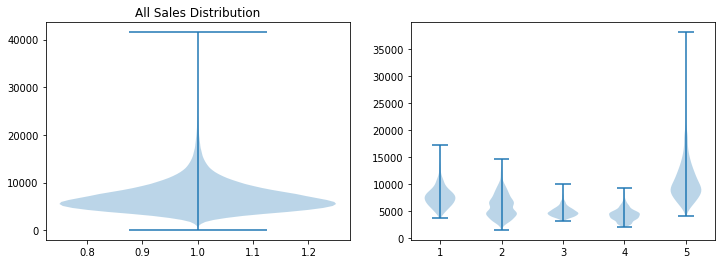

In [166]:
# 训练集整体销售额分布和随机抽取门店的销售额分布

figure = plt.figure(figsize=(12,4))
fig_1 = figure.add_subplot(121)
fig_2 = figure.add_subplot(122)

sales_all = train_raw.Sales.values
sample_sales = [train_raw[train_raw.Store==i].Sales.values for i in random.sample(range(1,1116),5)]
fig_1.violinplot(sales_all)
fig_2.violinplot(sample_sales)

fig_1.set_title('Distribution of All Sales ')
fig_1.set_title('Distribution of 5 random Stores')

可以看出，整体销售数据和每家门店的销售数据都在数值较大的方向出现了一个长尾巴，也就是存在一定的“异常值”或者说是“非常规销售额”，对于这些值，我并没有质疑其真实性，只是这些少量的非常规数据无法指导我们去分析大量的常规数据。因此，我计划以门店作为最小集和，对其依次进行异常截断。截断策略采用Turkey method, 对集和进行上异常截断。

In [200]:
# 定义截断值计算函数
def outlier_limit(array,k):
    # 1st quartile (25%)
    Q1 = np.percentile(array, 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(array,75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1
    upper_limit = Q3+k*IQR
    return upper_limit

k=1.5
# 计算每家店铺的上截断值
limits_for_stores = [outlier_limit(train_raw[(train_raw.Store==store_idx)].Sales.values,k) for store_idx in range(1,1116)]
# 计算异常值的数量
outliers = [train_raw[(train_raw.Store==store_idx)&(train_raw.Sales>limits_for_stores[store_idx-1])] for store_idx in range(1,1116)]
outliers_count = sum([len(i) for i in outliers])

print(outliers_count,'(',round(100*outliers_count/844338,3),'% of whole)','samples were determined as outliers')

16008 ( 1.896 % of whole) samples were determined as outliers


可以看出，数据集整体中有1.896%的数据被判断为异常值，剔除这些值并不会影响我们的模型训练。

In [241]:
# 剔除异常值
outliers_idx = []
for store_idx in range(1,1116):
    samples_one_store = train_raw[train_raw.Store==store_idx]
    outlier_limit = limits_for_stores[store_idx-1]
    outliers = samples_one_store[samples_one_store.Sales>outlier_limit]
    outliers_idx.append(outliers.index.tolist())
outliers = [i for j in outliers_idx for i in j]
train_raw.drop(outliers,axis=0,inplace=True)

Text(0.5,1,'Distribution of 5 random Stores')

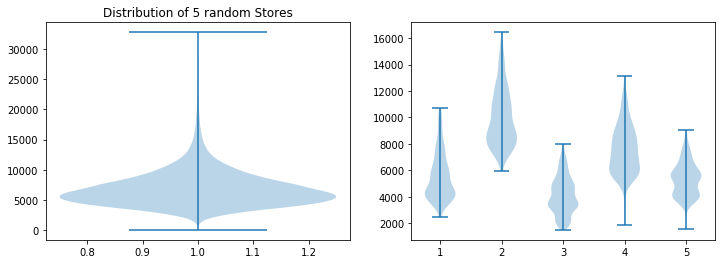

In [244]:
# 再次绘制整体和门店抽样的销售额分布图检验异常值提出效果

figure = plt.figure(figsize=(12,4))
fig_1 = figure.add_subplot(121)
fig_2 = figure.add_subplot(122)

sales_all = train_raw.Sales.values
sample_sales = [train_raw[train_raw.Store==i].Sales.values for i in random.sample(range(1,1116),5)]
fig_1.violinplot(sales_all)
fig_2.violinplot(sample_sales)

fig_1.set_title('Distribution of All Sales ')
fig_1.set_title('Distribution of 5 random Stores')

### 1.2. 无需处理或直接编码使用的特征处理

通过对train.csv和store.csv的观察，我挑选了以下特征作为本部分的处理对象。

 - 无需处理的特征：`Store, Open, Promo, SchoolHoliday, Customers, Sales, CompetitionDistance, Promo2`
 - 简单编码的特征：`StateHoliday, StoreType, Assortment, PromoInterval`

In [245]:
# 将原始数据集中可直接使用的信息放到good_train/good_test数据集中
ready_to_use = ['Store', 'Open', 'Promo', 'SchoolHoliday', 'Customers', 'Sales']

good_train = train_raw[simple_feature]
good_test = test_raw[simple_feature[:4]]

In [246]:
# features need OHE
good_train = ssf(good_train, store_raw)
good_test = ssf(good_test, store_raw)

good_train = OHE_stateholiday(train_raw, good_train)
good_test = OHE_stateholiday(test_raw, good_test)

good_train = OHE_storetype(good_train, store_raw)
good_test = OHE_storetype(good_test, store_raw)

good_train = OHE_assortment(good_train, store_raw)
good_test = OHE_assortment(good_test, store_raw)

good_train = OHE_promointerval(good_train, store_raw)
good_test = OHE_promointerval(good_test, store_raw)

C:\Users\siyuan\Dropbox\github\Rossmann-Sales\featuretank.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  good_df[feature] = good_df_feature
C:\Users\siyuan\Dropbox\github\Rossmann-Sales\featuretank.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  good_df['is_state_holiday'] = is_state_holiday


在经过编码后，数据集的特征发生了变化，以训练集为例，新的特征空间如下：

In [247]:
[i for i in good_train.columns.values]

['Store',
 'Open',
 'Promo',
 'SchoolHoliday',
 'Customers',
 'Sales',
 'CompetitionDistance',
 'Promo2',
 'is_state_holiday',
 'is_public_holiday',
 'is_easter',
 'is_christmas',
 'is_type_a',
 'is_type_b',
 'is_type_c',
 'is_type_d',
 'is_scale_a',
 'is_scale_b',
 'is_scale_c',
 'is_promo2_a',
 'is_promo2_b',
 'is_promo2_c']

### 1.3. 时间特征的处理

在原始数据中，时间特征以字符串形体提供（2015-07-31）。这显然是无法直接使用的，考虑到促销特征和竞争商家的时间特征格式（年、月、周）我决定将样本的时间特征拆分为`Year,Month,DayOfMonth,WeekOfYear,DayOfWeek`。

In [248]:
good_train = good_datetime(train_raw, good_train)
good_test = good_datetime(test_raw, good_test)

### 1.4. 新特征构造

虽然原始数据中的样本特征已经很丰富，也足够准确，但是有一些现实中存在潜在联系并没有表现出来。例如当前时间距离周期性促销活动还剩多久，竞争商家已经开业了多久了，这家门店是否火爆等等，这些信息需要在现有基础上进一挖掘。

在这一部分，我将在训练集和测试集中添加以下几个新的特征：

- CompetitionTime：竞争商家开业距今有多少月。
- Promo2Time：周年促销活动的第一次推出距今有多少月。
- Sales2013/2014/2015（三项）：2013/2014/2015年门店的平均销售额，作为门店特征对应到每条数据中。
- Heat2013/2014/2015（三项）：2013/2014/2015门店的平均销售额和平均客流量的商，作为门店热度对应到每条数据中。

In [249]:
# 计算并添加 competitiontime 和 promo2time 特征
good_train = competitiontime_promo2tim(good_train, store_raw)
good_test = competitiontime_promo2tim(good_test, store_raw)

# 计算并添加年均销售额和年均热度特征
good_train, good_test = sale_cus(good_train, good_test, store_raw)

# 由于客流量和销售额一样都是未知数据，测试集无法提供，所以训练集中的客流量无法在机器学习任务中使用，故剔除这一特征
good_train.drop(['Customers'], axis=1,inplace=True)

### 1.5. Adam 小结

至此，我完成了原始数据的无用值剔除、特征编码、时间特征拆分和新特征的构造工作。我将本部分成果保存为 `adam_train.csv, adam_test.csv`，adam中含有很多缺失值，但是例如xgboost这样的自带缺失填充功能的算法已经可以使用adam数据集进行训练和预测任务。

In [250]:
good_train.to_csv('data/adam_train.csv',index=False)
good_test.to_csv('data/adam_test.csv',index=False) 

In [251]:
good_train.head()

,Store,Open,Promo,SchoolHoliday,Sales,CompetitionDistance,Promo2,is_state_holiday,is_public_holiday,is_easter,...,WeekOfYear,DayOfWeek,CompetitionTime,Promo2Time,Sales2013,Sales2014,Sales2015,Heat2013,Heat2014,Heat2015
0,1,1,1,1,5263,1270.0,0,0,0,0,...,31,5,82.0,NaN,4843.312925,4627.023891,4538.426966,8.304275,8.462870,8.531869
1,2,1,1,1,6064,570.0,1,0,0,0,...,31,5,92.0,78.0,4841.525084,4937.726667,4932.615819,8.326427,8.477366,8.574587
2,3,1,1,1,8314,14130.0,1,0,0,0,...,31,5,103.0,65.0,6969.757576,6791.328859,6898.960674,9.112078,9.167909,9.536277
3,4,1,1,1,13995,620.0,0,0,0,0,...,31,5,70.0,NaN,9172.928328,9591.170068,9727.931034,7.104219,7.283041,7.459281
4,5,1,1,1,4822,29910.0,0,0,0,0,...,31,5,3.0,NaN,4596.349315,4627.387960,4623.782123,8.572321,8.659284,8.791207


## 2. Blanc

在这一部分，我将着手处理adam中的诸多缺失值，对于不同的特征，我会定义不同的策略来完成这一任务。

首先，为了防止变量混淆和内存过大，我将清空本notebook占用的所有内容。

In [252]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


这一部分的操作以adam为基础，引用必要的库和adam数据集

In [253]:
import pandas as pd
import numpy as np
from featuretank import *

In [254]:
train = pd.read_csv('data/adam_train.csv')
test = pd.read_csv('data/adam_test.csv')

### 2.1. 确定缺失内容

In [255]:
null_hunter(train)

['Store' 'Open' 'Promo' 'SchoolHoliday' 'Sales' 'CompetitionDistance'
 'Promo2' 'is_state_holiday' 'is_public_holiday' 'is_easter'
 'is_christmas' 'is_type_a' 'is_type_b' 'is_type_c' 'is_type_d'
 'is_scale_a' 'is_scale_b' 'is_scale_c' 'is_promo2_a' 'is_promo2_b'
 'is_promo2_c' 'Year' 'Month' 'DayOfMonth' 'WeekOfYear' 'DayOfWeek'
 'CompetitionTime' 'Promo2Time' 'Sales2013' 'Sales2014' 'Sales2015'
 'Heat2013' 'Heat2014' 'Heat2015']
CompetitionDistance miss 2140
is_promo2_a miss 415042
is_promo2_b miss 415042
is_promo2_c miss 415042
CompetitionTime miss 263454
Promo2Time miss 415042


In [256]:
null_hunter(test)

['Store' 'Open' 'Promo' 'SchoolHoliday' 'CompetitionDistance' 'Promo2'
 'is_state_holiday' 'is_public_holiday' 'is_easter' 'is_christmas'
 'is_type_a' 'is_type_b' 'is_type_c' 'is_type_d' 'is_scale_a' 'is_scale_b'
 'is_scale_c' 'is_promo2_a' 'is_promo2_b' 'is_promo2_c' 'Year' 'Month'
 'DayOfMonth' 'WeekOfYear' 'DayOfWeek' 'CompetitionTime' 'Promo2Time'
 'Sales2013' 'Sales2014' 'Sales2015' 'Heat2013' 'Heat2014' 'Heat2015']
Open miss 11
CompetitionDistance miss 96
is_promo2_a miss 17232
is_promo2_b miss 17232
is_promo2_c miss 17232
CompetitionTime miss 15216
Promo2Time miss 17232


从上面的输出结果可以看出，训练集和测试集均有样本缺失以下特征：

- 竞争商家信息
    - CompetitionDistance
    - CompetitionTime miss 
- 周年性促销信息
    - is_promo2_a miss （活动类型）
    - is_promo2_b miss （活动类型）
    - is_promo2_c miss （活动类型）
    - Promo2Time miss 

同时，测试集额外缺失 Open 特征。针对这三种缺失，我将分别制定填充策略。

### 2.2. 竞争商家信息缺失值填充

商家距离信息和开业时间信息我决定采用均值填充。

In [257]:
# 计算competitiondistance 和 competitiontime 的均值
cd_fill_value = np.mean([i for i in train.CompetitionDistance.values if not pd.isnull(i)])
ct_fill_value = np.mean([i for i in train.CompetitionTime.values if not pd.isnull(i)])

In [258]:
# 定义填充器
cd_filler = lambda x: cd_fill_value if pd.isnull(x) else x
ct_filler = lambda x: ct_fill_value if pd.isnull(x) else x
# 应用填充
train.CompetitionDistance = train.CompetitionDistance.apply(cd_filler)
train.CompetitionTime = train.CompetitionTime.apply(ct_filler)
test.CompetitionDistance = test.CompetitionDistance.apply(cd_filler)
test.CompetitionTime = test.CompetitionTime.apply(ct_filler)

### 2.3. 周年促销活动信息缺失值填充

缺失的特征中，周年促销活动的类型是确定的（无活动），所以类型特征均应为 0 值。如果按照同样的思路将促销活动距今的时间也设为0，那么将会混淆没有促销和促销刚开始这两种情况，完备样本中promo2time这一特征的值为正值（以月为单位），因此应对缺失值，我将使用该特征下所有非正数样本的均值进行填充。

In [259]:
# 定义和计算促销类别和距今时间的填充值
is_promo2_a_value = 0
is_promo2_b_value = 0
is_promo2_c_value = 0
p2t_fill_value = np.mean([i for i in train.Promo2Time.values if i<=0])
# 定义填充器
is_promo2_a_filler = lambda x: is_promo2_a_value if pd.isnull(x) else x
is_promo2_b_filler = lambda x: is_promo2_b_value if pd.isnull(x) else x
is_promo2_c_filler = lambda x: is_promo2_c_value if pd.isnull(x) else x
p2t_fill_filler = lambda x: p2t_fill_value if pd.isnull(x) else x
# 应用填充
train.is_promo2_a = train.is_promo2_a.apply(is_promo2_a_filler)
train.is_promo2_b = train.is_promo2_b.apply(is_promo2_b_filler)
train.is_promo2_c = train.is_promo2_c.apply(is_promo2_c_filler)
train.Promo2Time = train.Promo2Time.apply(p2t_fill_filler)
test.is_promo2_a = test.is_promo2_a.apply(is_promo2_a_filler)
test.is_promo2_b = test.is_promo2_b.apply(is_promo2_b_filler)
test.is_promo2_c = test.is_promo2_c.apply(is_promo2_c_filler)
test.Promo2Time = test.Promo2Time.apply(p2t_fill_filler)

### 2.4. 测试集Open特征的填充

我计划在这里进行一项小的机器学习任务来补全缺失的数据。我认为`'Store','Promo','is_state_holiday','SchoolHoliday','DayOfWeek'`这些特征和Open之间的关联度比较高。所以，我决定使用机器学习而不是人工判断的方法来建立缺失值的判断策略。算法我选择使用高效简单的随机森林算法。

In [260]:
# 准备针对Open特征的数据集,从整体训练集中筛选。
from featuretank import *

blanc_junior = pd.read_csv('data/train.csv',index_col=False)
blanc_junior = OHE_stateholiday(blanc_junior,blanc_junior)
blanc_junior_train_X = blanc_junior[['Store','Promo','is_state_holiday','SchoolHoliday','DayOfWeek']]
blanc_junior_train_y = blanc_junior.Open

# 训练模型并进行验证集评价
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def junior_clf_generator(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
    clf = RandomForestClassifier().fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(score)
    return clf, score

junior_clf,junior_score = junior_clf_generator(blanc_junior_train_X,blanc_junior_train_y)

C:\Users\siyuan\miniconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0.9970605872926928


可以看出验证评分相当高，这也说明选择的特征和Open之间的相关性确实很高

In [261]:
# 筛选出整体测试集中Open非空的部分作为随机森林分类器的测试部分
blanc_junior_test = test[pd.notnull(test.Open)]
blanc_junior_test_X = blanc_junior_test[['Store','Promo','is_state_holiday','SchoolHoliday','DayOfWeek']]
blanc_junior_test_y = blanc_junior_test.Open

# 在Open测试集上评价模型
junior_clf.score(blanc_junior_test_X,blanc_junior_test_y)

0.9987097402439321

测试结果也较好，说明分类器可以完成我们的目的：预测缺失Open数据的值

In [262]:
# 对测试集进行预测
blanc_test_open_pred = junior_clf.predict(test[['Store','Promo','is_state_holiday','SchoolHoliday','DayOfWeek']])

# 根据预测结果建立Open缺失值的填充策略
blanc_test_open_filled = []

for i in range(len(blanc_test_open_pred)):
    if pd.isnull(test.Open.values[i]):
        blanc_test_open_filled.append(blanc_test_open_pred[i])
    else:blanc_test_open_filled.append(test.Open.values[i])

# 将原有测试集中的Open列替换为填充过的值
test.Open = blanc_test_open_filled

再次检查训练集和测试集是否还有缺失值

In [263]:
null_hunter(train)

['Store' 'Open' 'Promo' 'SchoolHoliday' 'Sales' 'CompetitionDistance'
 'Promo2' 'is_state_holiday' 'is_public_holiday' 'is_easter'
 'is_christmas' 'is_type_a' 'is_type_b' 'is_type_c' 'is_type_d'
 'is_scale_a' 'is_scale_b' 'is_scale_c' 'is_promo2_a' 'is_promo2_b'
 'is_promo2_c' 'Year' 'Month' 'DayOfMonth' 'WeekOfYear' 'DayOfWeek'
 'CompetitionTime' 'Promo2Time' 'Sales2013' 'Sales2014' 'Sales2015'
 'Heat2013' 'Heat2014' 'Heat2015']


In [264]:
null_hunter(test)

['Store' 'Open' 'Promo' 'SchoolHoliday' 'CompetitionDistance' 'Promo2'
 'is_state_holiday' 'is_public_holiday' 'is_easter' 'is_christmas'
 'is_type_a' 'is_type_b' 'is_type_c' 'is_type_d' 'is_scale_a' 'is_scale_b'
 'is_scale_c' 'is_promo2_a' 'is_promo2_b' 'is_promo2_c' 'Year' 'Month'
 'DayOfMonth' 'WeekOfYear' 'DayOfWeek' 'CompetitionTime' 'Promo2Time'
 'Sales2013' 'Sales2014' 'Sales2015' 'Heat2013' 'Heat2014' 'Heat2015']


### 2.5. Blanc 小结

在这一部分，我检查了训练集和测试集中的缺失值，针对不同的缺失特征制定了不同的填充策略，我将本部分成果保存为 `blanc_train.csv, blanc_test.csv`，此时的数据已经可以供大部分机器学习算法使用。

In [265]:
# 保存结果
train.to_csv('data/blanc_train.csv',index=False)
test.to_csv('data/blanc_test.csv',index=False)
train.head()

,Store,Open,Promo,SchoolHoliday,Sales,CompetitionDistance,Promo2,is_state_holiday,is_public_holiday,is_easter,...,WeekOfYear,DayOfWeek,CompetitionTime,Promo2Time,Sales2013,Sales2014,Sales2015,Heat2013,Heat2014,Heat2015
0,1,1,1,1,5263,1270.0,0,0,0,0,...,31,5,82.0,-15.676936,4843.312925,4627.023891,4538.426966,8.304275,8.462870,8.531869
1,2,1,1,1,6064,570.0,1,0,0,0,...,31,5,92.0,78.000000,4841.525084,4937.726667,4932.615819,8.326427,8.477366,8.574587
2,3,1,1,1,8314,14130.0,1,0,0,0,...,31,5,103.0,65.000000,6969.757576,6791.328859,6898.960674,9.112078,9.167909,9.536277
3,4,1,1,1,13995,620.0,0,0,0,0,...,31,5,70.0,-15.676936,9172.928328,9591.170068,9727.931034,7.104219,7.283041,7.459281
4,5,1,1,1,4822,29910.0,0,0,0,0,...,31,5,3.0,-15.676936,4596.349315,4627.387960,4623.782123,8.572321,8.659284,8.791207


## 3. Cesar

在这一部分，我将对特征中的一些范围过大的信息进行放缩，以免结果受到数值本身的影响。

In [266]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [267]:
# 引用必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读入数据
train = pd.read_csv('data/blanc_train.csv',index_col=False)
test = pd.read_csv('data/blanc_test.csv',index_col=False)

In [268]:
train.columns.values

array(['Store', 'Open', 'Promo', 'SchoolHoliday', 'Sales',
       'CompetitionDistance', 'Promo2', 'is_state_holiday',
       'is_public_holiday', 'is_easter', 'is_christmas', 'is_type_a',
       'is_type_b', 'is_type_c', 'is_type_d', 'is_scale_a', 'is_scale_b',
       'is_scale_c', 'is_promo2_a', 'is_promo2_b', 'is_promo2_c', 'Year',
       'Month', 'DayOfMonth', 'WeekOfYear', 'DayOfWeek',
       'CompetitionTime', 'Promo2Time', 'Sales2013', 'Sales2014',
       'Sales2015', 'Heat2013', 'Heat2014', 'Heat2015'], dtype=object)

在多个特征中，`Sales，CompetitionDistance，CompetitionTime，Promo2Time，Sales2013/14/15，Heat2013/14/15`是取值范围比较宽的。我将通过观察他们的分布情况来决定是否需要缩放和使用什么方式来缩放。

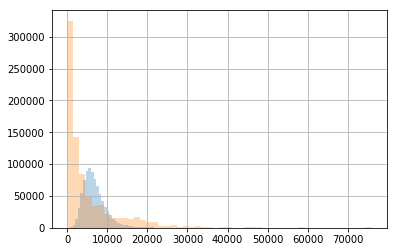

In [269]:
wide_features = ['Sales','CompetitionDistance','CompetitionTime','Promo2Time','Sales2013','Sales2014','Sales2015','Heat2013','Heat2014','Heat2015']

# 'Sales','CompetitionDistance'
for feature in wide_features[:2]:
    train[feature].hist(alpha=0.3,bins=50)

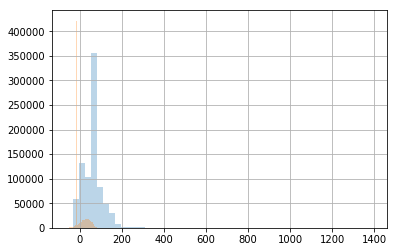

In [270]:
# 'CompetitionTime','Promo2Time'
for feature in wide_features[2:4]:
    train[feature].hist(alpha=0.3,bins=50)

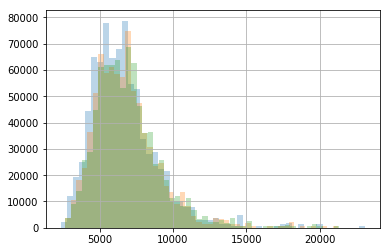

In [271]:
# 'Sales2013','Sales2014','Sales2015'
for feature in wide_features[4:7]:
    train[feature].hist(alpha=0.3,bins=50)

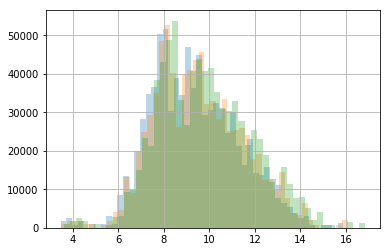

In [272]:
# 'Heat2013','Heat2014','Heat2015'
for feature in wide_features[7:]:
    train[feature].hist(alpha=0.3,bins=50)

经过分布图的观察，我认为`Sales，CompetitionDistance，CompetitionTime，Promo2Time，Sales2013/14/15`这些特征需要进行值缩小。考虑到训练集和测试集的统一，我认为对数处理是较为合理的。但是Promo2Time的值中有小于1的值，因此对于Promo2Time，需要首先所有值加上100再取对数。

In [273]:
# 明确放缩对象
wide_features = ['Sales','CompetitionDistance','CompetitionTime','Promo2Time','Sales2013','Sales2014','Sales2015']

# 定义放缩函数
def feature_rescale(df,features):
    for feature in features:
        if feature in ['Promo2Time','CompetitionTime']:
            old = df[feature].values+100
            df[feature]=np.log(old)
        else:  
            old = df[feature].values
            df[feature]=np.log(old)
    return df

# 在训练集和测试集上应用放缩
train = feature_rescale(train,wide_features)
test = feature_rescale(test,wide_features[1:])

# 查看效果
train.head()

,Store,Open,Promo,SchoolHoliday,Sales,CompetitionDistance,Promo2,is_state_holiday,is_public_holiday,is_easter,...,WeekOfYear,DayOfWeek,CompetitionTime,Promo2Time,Sales2013,Sales2014,Sales2015,Heat2013,Heat2014,Heat2015
0,1,1,1,1,8.568456,7.146772,0,0,0,0,...,31,5,5.204007,4.434655,8.485354,8.439669,8.420336,8.304275,8.462870,8.531869
1,2,1,1,1,8.710125,6.345636,1,0,0,0,...,31,5,5.257495,5.181784,8.484985,8.504660,8.503625,8.326427,8.477366,8.574587
2,3,1,1,1,9.025696,9.556055,1,0,0,0,...,31,5,5.313206,5.105945,8.849336,8.823402,8.839126,9.112078,9.167909,9.536277
3,4,1,1,1,9.546455,6.429719,0,0,0,0,...,31,5,5.135798,4.434655,9.124012,9.168598,9.182757,7.104219,7.283041,7.459281
4,5,1,1,1,8.480944,10.305948,0,0,0,0,...,31,5,4.634729,4.434655,8.433018,8.439748,8.438968,8.572321,8.659284,8.791207


另外，商店信息已经通过样本中的各种描述来表征了，所以我认为商店编号Store并没有什么用

In [274]:
# 删除商店编号
train.drop(['Store'],axis=1,inplace=True)
test.drop(['Store'],axis=1,inplace=True)

# 保存成果
train.to_csv('data/cesar_train.csv',index=False)
test.to_csv('data/cesar_test.csv',index=False)